<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/architectures/architectures/Principal%20Component%20Analysis(PCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Imports

In [68]:
import re
import spacy
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
np.random.seed(42)

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

nlp = spacy.load('en', disable=['parser', 'ner'])

### 20 Newsgroup Dataset

In [75]:
categories = ['alt.atheism', 'comp.graphics', 'rec.sport.hockey', 'sci.space']
dataset = fetch_20newsgroups(shuffle=True, categories=categories, random_state=42, remove=('headers', 'footers', 'quotes'))
len(dataset.data)

2257

In [76]:
dataset.target_names

['alt.atheism', 'comp.graphics', 'rec.sport.hockey', 'sci.space']

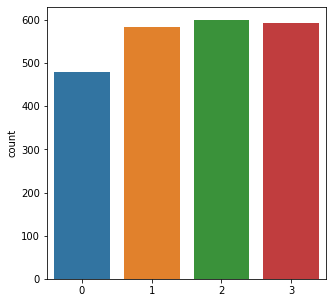

In [77]:
plt.figure(figsize=(5, 5))
sns.countplot(dataset.target)

In [78]:
data = dataset.data

### Tokenization

In [79]:
def sentence_to_tokens(sent):
    # remove emails
    sent = re.sub(r'\S*@\S*\s?', '', sent)
    # remove newline chars
    sent = re.sub(r'\s+', ' ', sent)
    # remove single quotes
    sent = re.sub(r"\'", "", sent)
    # converts to lower case tokens and removes tokens that are
    # too small & too long. Also remove accent characters & punct
    tokens = simple_preprocess(str(sent), deacc=True)
    return tokens

In [80]:
%%time
tokenized_data = [sentence_to_tokens(doc) for doc in data]

CPU times: user 1.19 s, sys: 2.99 ms, total: 1.2 s
Wall time: 1.2 s


In [81]:
" ".join(tokenized_data[0])

'in fact you can all direct your ire at the proper target by ingoring nasa altogether the rocket is commercial launch vechicle conestoga flying comet payload nasa is simply the primary customer believe sdio has small payload as well the advertising space was sold by the owners of the rocket who can do whatever they darn well please with it in addition these anonymous observers had no reason to be startled the deal made space news at least twice think its only fair to find that out before everyone starts having hissy fit the fact that they bothered to use the conditional tense suggests that it has not yet been approved'

### Pre-processing

In [82]:
%%time
# create bigrams from the tokenized data
bigram = gensim.models.Phrases(tokenized_data, threshold=50)
# make a bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)

CPU times: user 2.65 s, sys: 5.97 ms, total: 2.65 s
Wall time: 2.66 s


In [83]:
def process_words(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # remove stopwords
    stop_free = [[word for word in doc if word not in stop_words] for doc in texts]
    # bigrams
    bigram_data = [bigram_mod[doc] for doc in stop_free]

    texts_out = []
    for sent in bigram_data:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    # join words into sentence in-order to make it useful to tfidf processing
    texts_out = [" ".join(words) for words in texts_out]
    return texts_out

In [84]:
%%time
processed_data = process_words(tokenized_data)

CPU times: user 16.3 s, sys: 44.8 ms, total: 16.4 s
Wall time: 16.4 s


In [85]:
processed_data[0]

'fact direct ire proper target ingore altogether rocket commercial launch vechicle conestoga fly simply primary customer believe small payload advertising space sell owner rocket addition anonymous observer reason startled deal make space news least twice think fair find start fact bother conditional tense suggest yet approve'

### Tfidf

In [86]:
tfidf = TfidfVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')

data_vectorized = tfidf.fit_transform(processed_data)

### PCA using 2 components

In [87]:
pca_2 = PCA(n_components=2)

In [88]:
%%time
pca_2.fit(data_vectorized.toarray())

CPU times: user 494 ms, sys: 51 ms, total: 545 ms
Wall time: 308 ms


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [89]:
pca_2.explained_variance_ratio_

array([0.01254844, 0.00904498])

In [90]:
pca_2.singular_values_

array([5.16886601, 4.38837854])

In [128]:
transformed = pca_2.transform(data_vectorized.toarray())
transformed.shape

(2257, 2)

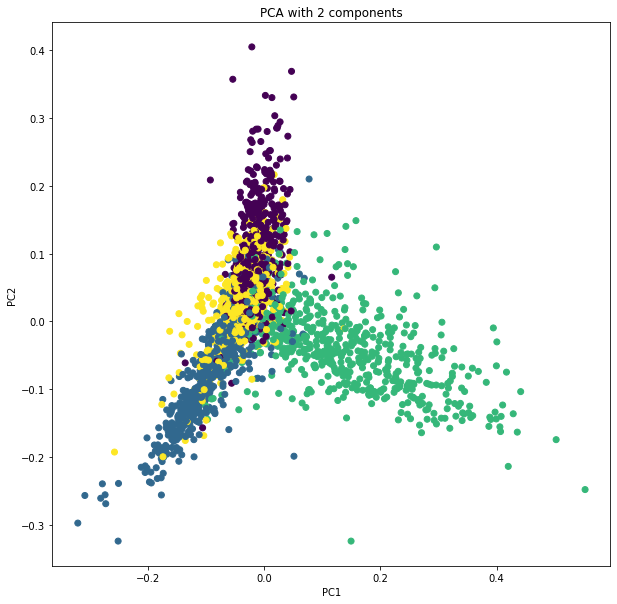

In [137]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.scatter(transformed[:, 0], transformed[:, 1], c=dataset.target)
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA with 2 components")
plt.show()

### PCA using 3 components

In [93]:
pca_3 = PCA(n_components=3)

In [94]:
pca_3.fit(data_vectorized.toarray())

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [95]:
pca_3.explained_variance_ratio_

array([0.01254845, 0.00904498, 0.00673813])

In [96]:
pca_3.singular_values_

array([5.1688664 , 4.38837816, 3.78765193])

In [138]:
transformed_3 = pca_3.transform(data_vectorized.toarray())
transformed_3.shape

(2257, 3)

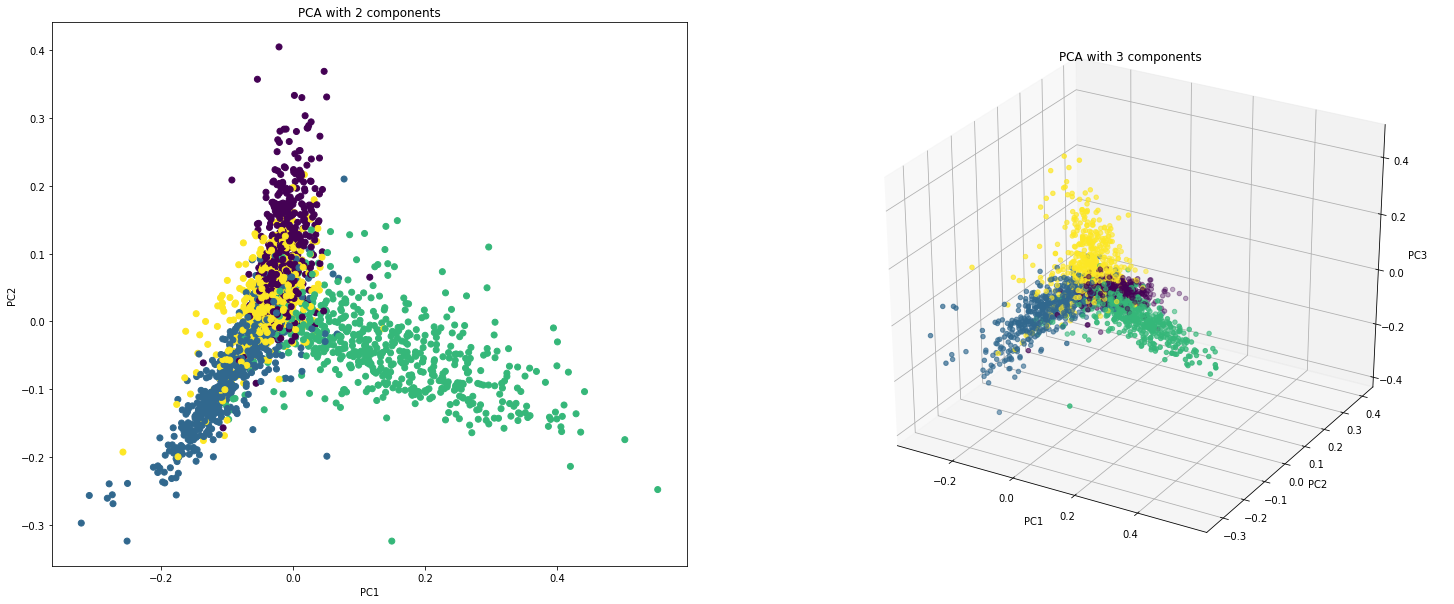

In [146]:
fig = plt.figure(figsize=(25, 10))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(transformed[:, 0], transformed[:, 1], c=dataset.target)
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA with 2 components")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(transformed_3[:, 0], transformed_3[:, 1], transformed_3[:, 2], c=dataset.target, marker='o')
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA with 3 components")
plt.show()

### Let's add the pca axis

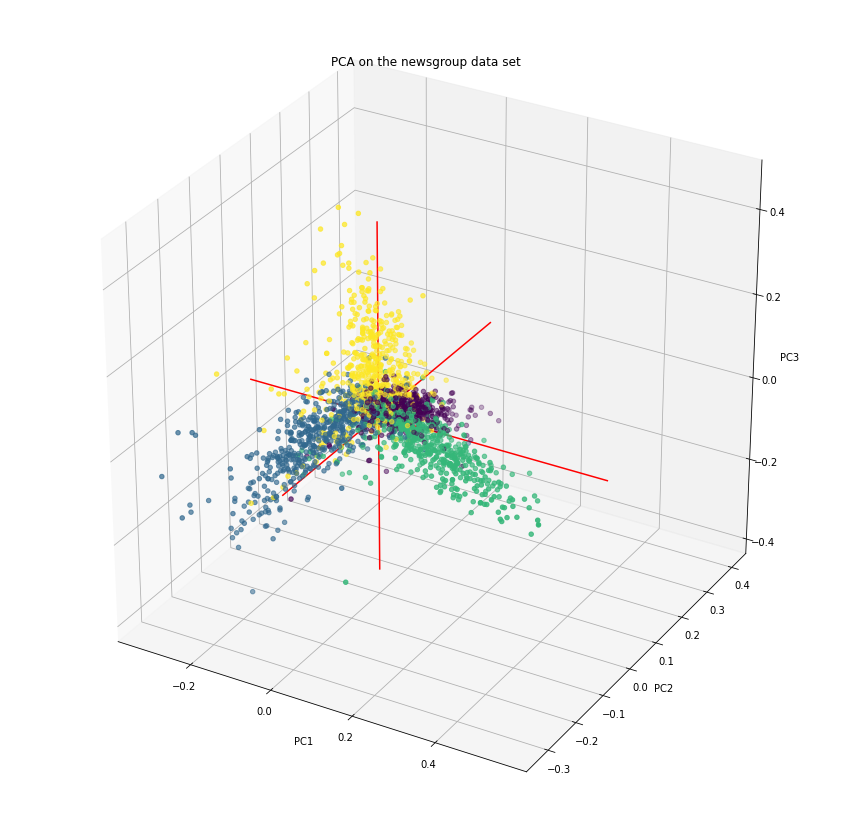

In [127]:
# Store results of PCA in a data frame
result=pd.DataFrame(transformed, columns=['PCA%i' % i for i in range(3)])
 
# Plot initialisation
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=dataset.target)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the newsgroup data set")
plt.show()